In [21]:
from sys import byteorder
from array import array
from struct import pack

import pyaudio
import wave

THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 44100

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 30:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
def record_to_arr():
    sample_width,data = record()
    return sample_width,data

def save_arr_as_wav(sample_width,data,path):
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [11]:
print("please speak a word into the microphone")
record_to_file('demo.wav')
print("done - result written to demo.wav")

please speak a word into the microphone
121740
done - result written to demo.wav


In [20]:
sample_width,my_arr = record_to_arr()

In [27]:
import numpy as np
save_arr_as_wav(sample_width,np.array(my_arr)*10,"demo_2.wav")

## During this project, you will work to hide around 2 minutes of audio into an image so that only you or anyone you give the "key" can see the hidden audio



In [2]:
import matplotlib.pyplot as plt

In [105]:
import numpy as np
import scipy.io.wavfile
import time

audioTest = scipy.io.wavfile.read("audio_2_mono.wav")
timeOfAudio = len(audioTest[1])/audioTest[0]
print("Audio Time: {} secs".format(timeOfAudio))
print("Sampling Rate: {}Hz".format(audioTest[0]))

def printAudioDetails(file):
    print("Max value is {}, Min value is {}, Average is {}, Variance is {}".format(max(file),min(file),sum(file)/len(file),np.var(file)))
    
audioFile  = audioTest[1]
printAudioDetails(audioFile)
avg = np.mean(audioFile)
var = np.var(audioFile)
subtracted_val = min(audioFile)
normalized = np.array(audioFile-min(audioFile))
divided_val = max(normalized)
normalized = normalized/max(normalized)
printAudioDetails(normalized)

Audio Time: 205.00897959183675 secs
Sampling Rate: 44100Hz
Max value is 21827, Min value is -25789, Average is -0.02435953250651263, Variance is 1695055.3343740755
Max value is 1.0, Min value is -1.000030518509476, Average is 0.7835462045610339, Variance is 0.006611459908491989


In [106]:
hidden_factor = 0.02
to_add_1d = hidden_factor*normalized

In [107]:
import cv2
im = cv2.imread("dog.jpg")
number_of_elements = im.shape[0]*im.shape[1]*im.shape[2]
print(number_of_elements)

8294400


In [108]:
to_add_2d = to_add_1d[:number_of_elements].reshape(im.shape[0],im.shape[1],im.shape[2])

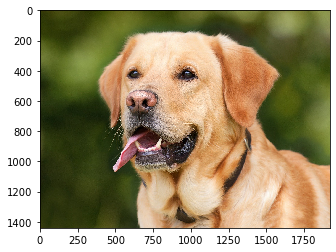

In [109]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


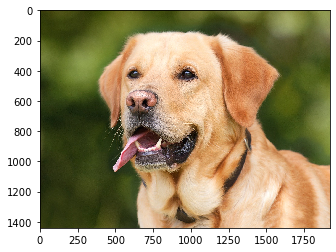

In [110]:
correct_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
new_image = (correct_im/255)+to_add_2d
plt.imshow(new_image)

In [122]:
original_message = new_image-correct_im/255
original_message = original_message.reshape(number_of_elements)/hidden_factor
print(original_message.shape)

(8294400,)


In [123]:
original_message = (original_message*divided_val)+subtracted_val
original_message = np.array(original_message,dtype=np.int32)

In [124]:
from scipy.io.wavfile import write

In [125]:
write('test_2.wav', 44100, original_message)

In [126]:
print(original_message)

[-3.63797881e-12 -3.63797881e-12 -3.63797881e-12 ...  1.37000000e+02
  1.35000000e+02  1.29000000e+02]


In [127]:
print(audioFile)

[ 0  0  0 ... -1 -2  2]
